In [9]:
import glob
import numpy as np
import pandas as pd
import geopandas as gpd
import clima_anom as ca

import matplotlib.cbook
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

import cartopy
import cartopy.feature as cf
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy.io.shapereader as shpreader

import sys
sys.path.append('../../function/')
from Funciones import dbz2mm, mm2dbz

In [2]:
data_input = '/mnt/Data/Data/PF/TRMM/rpf_SA/RP/rpf_RP_200101_level2.csv'
data = pd.read_csv(data_input, sep=',')
data[data==-88.88] = np.nan
data[data==-99.99] = np.nan
data.head(10)

,lat,lon,0.5,1.0,1.5,2.0,2.5,3.0,3.5,4.0,...,15.5,16.0,16.5,17.0,17.5,18.0,18.5,19.0,19.5,20.0
0,13.080000,-37.5800,NaN,NaN,NaN,8.58,12.32,11.88,9.84,13.01,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,14.720000,-62.6500,NaN,NaN,26.42,25.37,17.13,0.00,0.00,0.00,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,14.295000,-60.9925,NaN,11.73,34.25,31.67,28.56,20.16,17.53,0.00,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,14.210000,-60.8750,NaN,6.25,30.83,30.23,22.89,0.00,0.00,0.00,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,14.087500,-60.5800,NaN,4.35,23.31,24.31,21.27,14.21,0.00,0.00,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,13.160000,-61.1650,NaN,NaN,NaN,27.96,31.19,23.87,14.67,0.00,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,13.262501,-60.7125,NaN,NaN,31.78,31.34,27.60,20.96,16.45,0.00,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,13.550000,-60.3200,NaN,21.41,19.07,16.98,0.00,0.00,0.00,0.00,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,13.440000,-59.9400,NaN,-17.29,18.94,19.62,0.10,0.00,0.00,0.00,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,13.180000,-59.5600,NaN,NaN,-10.46,22.36,20.22,0.00,0.00,0.00,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [3]:
levels = np.arange(0.5,20.5,0.5)
len(levels)

40

In [4]:
dbz = data.loc[105][2:].values

In [5]:
R = dbz2mm(dbz)

In [6]:
dbz2 = mm2dbz(R)

In [10]:
PF_GPD = gpd.GeoDataFrame(data[data.columns[2:]], geometry=gpd.points_from_xy(data['lon'],data['lat'], crs="EPSG:4326"))

In [35]:
comm_GPD = gpd.read_file('/mnt/Data/Github/Complex-Network-AS/mapping/communities/Comm_IMERG_05x05_sync_summer_P90_tau3_SP95.shp')

In [16]:
num_comm = len(comm_GPD['geometry'])
num_points = len(PF_GPD['geometry'])

1

In [44]:
points_interception = []   

for t in range(num_points):

    if comm_GPD['geometry'][0].contains(PF_GPD['geometry'][t]) == True:
        points_interception.append(t)

dic_tmp = PF_GPD.loc[points_interception]
dic_tmp = dic_tmp.reset_index(drop=True)

In [60]:
dic_tmp

,0.5,1.0,1.5,2.0,2.5,3.0,3.5,4.0,4.5,5.0,...,16.0,16.5,17.0,17.5,18.0,18.5,19.0,19.5,20.0,geometry
0,NaN,NaN,NaN,18.69,20.51,21.48,22.86,24.27,26.83,24.16,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,POINT (-61.56428 -3.78000)
1,NaN,NaN,2.58,17.71,18.00,14.59,19.50,17.94,20.92,19.72,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,POINT (-60.07000 -4.27000)
2,NaN,NaN,16.11,0.00,0.00,0.00,0.00,19.16,20.70,24.79,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,POINT (-59.73000 -4.03000)
3,NaN,-14.66,0.00,15.49,0.54,17.96,16.79,19.76,21.24,19.62,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,POINT (-59.66000 -3.99000)
4,NaN,-4.00,20.08,19.18,20.82,23.33,22.02,21.43,25.52,24.11,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,POINT (-59.52800 -3.95000)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10946,NaN,NaN,NaN,24.41,35.85,36.95,37.90,39.57,40.84,37.45,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,POINT (-56.32642 -13.62857)
10947,NaN,NaN,25.78,26.18,28.04,29.87,29.72,28.40,26.98,27.78,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,POINT (-56.21250 -15.01500)
10948,NaN,NaN,5.46,30.33,31.06,30.93,28.24,26.31,23.62,0.00,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,POINT (-55.98500 -14.82000)
10949,NaN,NaN,NaN,NaN,21.57,21.28,17.48,0.00,0.00,0.00,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,POINT (-55.27500 -14.43500)


In [67]:
salida = np.zeros((len(dic_tmp),40))

for n in range(len(dic_tmp)):
    tmp = dic_tmp.loc[n][0:40].values
    salida[n,:] = dbz2mm(tmp)

In [86]:
salida_mean = np.nanmean(salida, axis=0)
salida_mean.shape

/tmp/ipykernel_78305/2972676557.py:1: RuntimeWarning: Mean of empty slice
  salida_mean = np.nanmean(salida, axis=0)


(40,)

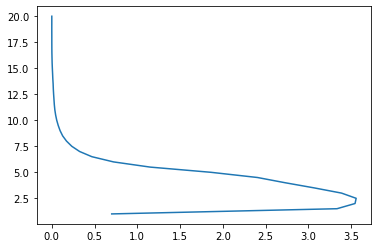

In [80]:
plt.plot(salida_mean,levels)

In [89]:
salida_mean_dbz = mm2dbz(salida_mean)
salida_mean_dbz[salida_mean_dbz<0] = np.nan

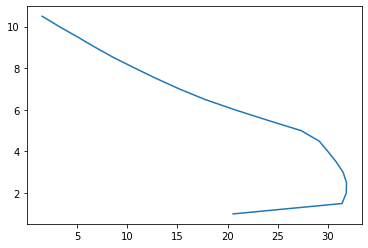

In [90]:
plt.plot(salida_mean_dbz,levels)